In [1]:
import os
import sys
import importlib
from pathlib import Path
from itertools import product
import h5py

import gym
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.ndimage
import skimage.transform
import torch as th
import torch.nn as nn

from tqdm.auto import tqdm

from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.vec_env import VecEnvWrapper, VecEnv, DummyVecEnv
from stable_baselines3.common.vec_env import VecTransposeImage

sys.path.insert(1, "../rl-baselines3-zoo")
import utils.import_envs  # noqa: F401 pylint: disable=unused-import
from utils.utils import StoreDict
from utils import ALGOS, create_test_env, get_latest_run_id, get_saved_hyperparams

/home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/eric/Co

In [2]:
########### Set Device ############
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
dtype = th.float32
th.set_default_dtype(dtype)
print("Using device: {}".format(device))

Using device: cuda


In [3]:
env_id = "BreakoutNoFrameskip-v4"
folder = "../agents"
algo = "a2c"
n_timesteps = 10000
num_threads = -1
n_envs = 1
exp_id = 3
verbose = 1
no_render = False
deterministic = False
load_best = True
load_checkpoint = None
norm_reward = False
seed = 0
reward_log = ''
env_kwargs = None

In [4]:
# Sanity checks
if exp_id > 0:
    log_path = os.path.join(folder, algo, '{}_{}'.format(env_id, exp_id))
else:
    log_path = os.path.join(folder, algo)
    
found = False
for ext in ['zip']:
    model_path = os.path.join(log_path, f'{env_id}.{ext}')
    found = os.path.isfile(model_path)
    if found:
        break

if load_best:
    model_path = os.path.join(log_path, "best_model.zip")
    found = os.path.isfile(model_path)

if load_checkpoint is not None:
    model_path = os.path.join(log_path, f"rl_model_{load_checkpoint}_steps.zip")
    found = os.path.isfile(model_path)

if not found:
    raise ValueError(f"No model found for {algo} on {env_id}, path: {model_path}")

if algo in ['dqn', 'ddpg', 'sac', 'td3']:
    n_envs = 1

set_random_seed(seed)

if num_threads > 0:
    if verbose > 1:
        print(f"Setting torch.num_threads to {num_threads}")
    th.set_num_threads(num_threads)

is_atari = 'NoFrameskip' in env_id

stats_path = os.path.join(log_path, env_id)
hyperparams, stats_path = get_saved_hyperparams(stats_path, norm_reward=norm_reward, test_mode=True)
env_kwargs = {} if env_kwargs is None else env_kwargs

log_dir = reward_log if reward_log != '' else None

env = create_test_env(env_id, n_envs=n_envs,
                      stats_path=stats_path, seed=seed, log_dir=log_dir,
                      should_render=not no_render,
                      hyperparams=hyperparams,
                      env_kwargs=env_kwargs)

model = ALGOS[algo].load(model_path, env=env)

obs = env.reset()

Stacking 4 frames


In [5]:
class RewardData(th.utils.data.Dataset):
    def __init__(self, train=True):
        self.f = h5py.File(f"../datasets/rewards_{env_id}.hdf5", 'r')
        if train:
            self.group = self.f['train']
        else:
            self.group = self.f['test']
    
    def __getitem__(self, k):
        if k % 2 == 0:
            input = self.group['zeros-inputs'][k // 2]
            label = self.group['zeros-labels'][k // 2]
            return (input, label)
        else:
            input = self.group['ones-inputs'][k // 2]
            label = self.group['ones-labels'][k // 2]
            return (input, label)
    
    def __len__(self):
        return self.group['ones-labels'].shape[0] + self.group['zeros-labels'].shape[0]
    
    def close(self):
        self.f.close()
        
class RewardModel(nn.Module):
    """A reward model using an A2C feature extractor"""
    def __init__(self, env, device):
        super(RewardModel, self).__init__()
        self.ac_model = ALGOS['a2c']('CnnPolicy', env).policy
        self.reward_net = nn.Linear(512, 1).to(device)
        self.device = device
    
    def forward(self, obs):
        obs_transposed = VecTransposeImage.transpose_image(obs)
        latent, _, _= self.ac_model._get_latent(th.tensor(obs_transposed).to(self.device))
        return self.reward_net(latent)
    
    def freeze_extractor(self):
        for p in self.ac_model.policy.features_extractor.parameters():
            p.requires_grad = False

In [6]:
def create_circular_mask(h, w, center, radius=5):
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[1])**2 + (Y-center[0])**2)
    mask = dist_from_center <= radius
    return np.array(mask, dtype=np.float32)

def max_k(k, iterator, key=lambda x: x):
    items = [None for _ in range(k)]
    values = [-float('inf') for _ in range(k)]
    for item in iterator:
        val = key(item)
        for i in range(k):
            if val > values[i]:
                items.insert(i, item)
                items.pop()
                values.insert(i, val)
                values.pop()
                break
    return items

def max_k_and_values(k, iterator, key=lambda x: x):
    items = [None for _ in range(k)]
    values = [-float('inf') for _ in range(k)]
    for item in iterator:
        val = key(item)
        for i in range(k):
            if val > values[i]:
                items.insert(i, item)
                items.pop()
                values.insert(i, val)
                values.pop()
                break
    return list(zip(items, values))

loss_fn = th.nn.MSELoss()
def policy_saliency(model, obs, loc, radius=5, device='cuda'):
    obs_transposed = VecTransposeImage.transpose_image(np.copy(obs))
    latent, _, _ = model.policy._get_latent(th.from_numpy(obs_transposed).to(device))
    baseline = model.policy.action_net(latent)
    M = create_circular_mask(84, 84, center=loc, radius=radius)
    for k in range(4):
        img = obs_transposed[0, k, :, :]
        A = scipy.ndimage.gaussian_filter(img, 3)
        obs_transposed[0, k, :, :] = img*(1 - M) + A*M
    latent, _, _ = model.policy._get_latent(th.from_numpy(obs_transposed).to(device))
    modified = model.policy.action_net(latent)
    return loss_fn(baseline, modified).item()

def value_saliency(model, obs, loc, radius=5, device='cuda'):
    obs_transposed = VecTransposeImage.transpose_image(np.copy(obs))
    latent, _, _ = model.policy._get_latent(th.from_numpy(obs_transposed).to(device))
    baseline = model.policy.value_net(latent)
    M = create_circular_mask(84, 84, center=loc, radius=radius)
    for k in range(4):
        img = obs_transposed[0, k, :, :]
        A = scipy.ndimage.gaussian_filter(img, 3)
        obs_transposed[0, k, :, :] = img*(1 - M) + A*M
    latent, _, _ = model.policy._get_latent(th.from_numpy(obs_transposed).to(device))
    modified = model.policy.value_net(latent)
    return loss_fn(baseline, modified).item()

def reward_model_saliency(model: RewardModel, obs, loc, radius=5, device='cuda'):
    obs_copy = np.copy(obs)
    baseline = model(obs_copy)
    M = create_circular_mask(84, 84, center=loc, radius=radius)
    for k in range(4):
        img = obs_copy[0, :, :, k]
        A = scipy.ndimage.gaussian_filter(img, 3)
        obs_copy[0, :, :, k] = img*(1 - M) + A*M
    modified = model(obs_copy)
    return loss_fn(baseline, modified).item()

def invert_preprocessing(loc):
    x, y = loc
    return (int(210/84*x), int(160/84*y))

In [11]:
obs = env.reset()
for i in range(1500):
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    if done:
        break

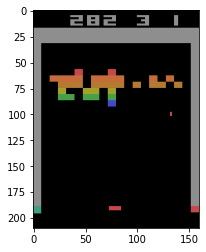

In [12]:
plt.imshow(env.get_images()[0])

# Danger zone: train the reward model:

In [10]:
train = RewardData(train=True)
test = RewardData(train=False)

In [11]:
train_loader = th.utils.data.DataLoader(train, batch_size=20, shuffle=True, num_workers=0)
test_loader = th.utils.data.DataLoader(test, batch_size=20, shuffle=False, num_workers=0)

In [71]:
rm = RewardModel(env, device)

In [72]:
optimizer = th.optim.Adam(rm.parameters())
loss_fn = th.nn.MSELoss(reduction="sum")

In [1]:
num_batches = 0
for samples, targets in tqdm(train_loader):
    if targets.max() > 1:
        print(targets.max())
    optimizer.zero_grad()
    batch_loss = loss_fn(rm(samples), targets.to(device))
    batch_loss.backward()
    optimizer.step()
    num_batches += 1
    if num_batches % 2000 == 0:
        print(batch_loss)

NameError: name 'tqdm' is not defined

# Let's train the reward model for a few more epochs

In [78]:
num_batches = 0
for _ in range(3):
    for samples, targets in tqdm(train_loader):
        if targets.max() > 1:
            print(targets.max())
        optimizer.zero_grad()
        batch_loss = loss_fn(rm(samples), targets.to(device))
        batch_loss.backward()
        optimizer.step()
        num_batches += 1
        if num_batches % 2000 == 0:
            print(batch_loss)

tensor(0.0169, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.8310, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0308, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.1667, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0961, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(1.7100, device='cuda:0', grad_fn=<MseLossBackward>)



tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0147, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.3260, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(1.1170, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0592, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0073, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0051, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0154, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0941, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0331, device='cuda:0', grad_fn=<MseLossBackward>)



tensor(0.2228, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0054, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0267, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0309, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0033, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0387, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0258, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(1.0268, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.1005, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0307, device='cuda:0', grad_fn=<MseLossBackward>)



In [100]:
outof = 0
testing_loss = 0
with th.no_grad():
    for sample, target in tqdm(test_loader):
        output = rm(sample)
        testing_loss += loss_fn(output, target.to(device))
        outof += len(target)
testing_loss = float(testing_loss / outof)

In [101]:
print(testing_loss)

0.07567251473665237


# Okay so this is a great reward model. Let's save it.

In [103]:
th.save(rm.state_dict(), "breakout_rm_v1.pt")

# Done saving. Let's illustrate an important point: the block disappears, and the score changes, in the frame __after__ the reward is returned.

In [9]:
rm = RewardModel(env, device)

In [10]:
rm.load_state_dict(th.load("../reward-models/breakout_rm_v1.pt"))

<All keys matched successfully>

In [11]:
obs = env.reset()
for i in range(500):
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    if reward:
        break

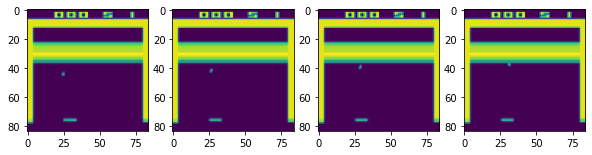

In [12]:
plt.figure(figsize=(10, 4))
for k in range(4):
    plt.subplot(1, 4, k+1)
    plt.imshow(obs[0, :, :, k])

0.0


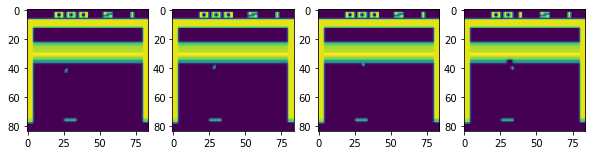

In [13]:
action, _states = model.predict(obs, deterministic=False)
obs, reward, done, info = env.step(action)
print(reward[0])

plt.figure(figsize=(10, 4))
for k in range(4):
    plt.subplot(1, 4, k+1)
    plt.imshow(obs[0, :, :, k])

# Ahhhhhh. The score doesn't change on the screen, and the block doesn't disappear, until the frame after the reward is returned. That's why the score region isn't salient.

Let's now tune the saliency map settings

In [14]:
obs = env.reset()
for i in range(500):
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    if reward:
        break

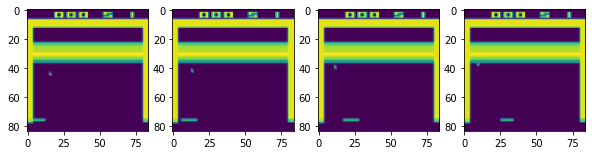

In [15]:
plt.figure(figsize=(10, 4))
for k in range(4):
    plt.subplot(1, 4, k+1)
    plt.imshow(obs[0, :, :, k])

In [27]:
obs = env.reset()
for i in range(500):
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    if reward:
        break

0.9512961506843567
0.699923574924469
0.596564769744873
0.5756155848503113
0.37858477234840393
0.15966618061065674
0.14902833104133606
0.1412266343832016
0.14045892655849457
0.07166562974452972


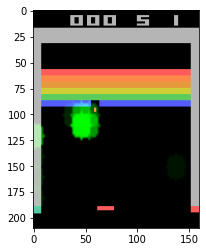

In [34]:
radius = 5
stride = 4

pairs = max_k_and_values(10, product(range(0, 84, stride), range(0, 84, stride)), key=lambda e: reward_model_saliency(rm, obs, e, radius=radius))
screenshot = env.get_images()[0]
screenshot = screenshot / screenshot.max()
max_value = pairs[0][1]
for loc, value in pairs:
    print(value)
    spot = value*create_circular_mask(84, 84, center=loc, radius=radius)
    spot = skimage.transform.resize(spot, (210, 160))
    screenshot[:, :, 1] = spot + (1-spot)*screenshot[:, :, 1]
    screenshot = screenshot / screenshot.max()
plt.imshow(screenshot)

In [36]:
matplotlib.use("Agg")
import matplotlib.animation as manimation

import warnings
warnings.filterwarnings("ignore")

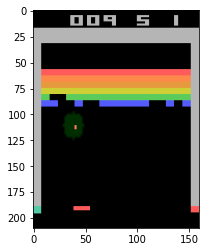

In [38]:
radius = 5
stride = 4

TIMESTEPS = 300

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title=f"Breakout Policy Saliency Map", artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=20, metadata=metadata)

fig, ax = plt.subplots(1, 1)

obs = env.reset()
imshow = ax.imshow(env.get_images()[0])
with writer.saving(fig, "../videos/breakout_reward_model_saliency_mag.mp4", dpi=200):
    for i in tqdm(range(TIMESTEPS)):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        if done:
            break
        pairs = max_k_and_values(5, product(range(0, 84, stride), range(0, 84, stride)), key=lambda e: reward_model_saliency(rm, obs, e, radius=radius))
        screenshot = env.get_images()[0]
        screenshot = screenshot / screenshot.max()
#         screenshot = screenshot * 0.4
        for loc, value in pairs:
            spot = value*create_circular_mask(84, 84, center=loc, radius=radius)
            spot = skimage.transform.resize(spot, (210, 160))
            screenshot[:, :, 1] = spot + (1-spot)*screenshot[:, :, 1]
            screenshot = screenshot / screenshot.max()
        imshow.set_data(screenshot)
        writer.grab_frame()

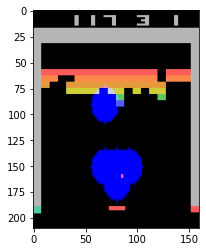

In [81]:
radius = 7
stride = 6

TIMESTEPS = 300

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title=f"Breakout Policy Saliency Map", artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=20, metadata=metadata)

fig, ax = plt.subplots(1, 1)

obs = env.reset()
for i in range(1100):
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    if done:
        break

imshow = ax.imshow(env.get_images()[0])
with writer.saving(fig, "../videos/breakout_reward_model_saliency_later.mp4", dpi=200):
    for i in tqdm(range(TIMESTEPS)):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        if done:
            break
        locs = max_k(5, product(range(0, 84, stride), range(0, 84, stride)), key=lambda e: reward_model_saliency(rm, obs, e, radius=radius))
        screenshot = env.get_images()[0]
        screenshot = screenshot / screenshot.max()
#         screenshot = screenshot * 0.4
        for loc in locs:
            spot = 1.0*create_circular_mask(84, 84, center=loc, radius=radius)
            spot = skimage.transform.resize(spot, (210, 160))
            screenshot[:, :, 2] = spot + (1-spot)*screenshot[:, :, 2]
            screenshot = screenshot / screenshot.max()
        imshow.set_data(screenshot)
        writer.grab_frame()